# Business and data understanding

## Purpose
This notebook contains the data preparation phase for the .

## Tasks
- [x] Attributes that are present in training and testing datasets:
    - 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'
- [x] Atributte 'Dates' will be replaced by 'dates_year', 'dates_month', 'dates_day', 'dates_hour', 'is_daytime'.
- [x] Attribute 'Address' will be replaced by 'simplified_address'
- [x] Attributes 'X' and 'Y' needs a preprocessing to replace 67

# Setup

## Library import

In [2]:
from datetime import datetime 
import os
from pathlib import Path

from feature_engine.encoding import CountFrequencyEncoder, RareLabelEncoder, OneHotEncoder, OrdinalEncoder
import folium
import humps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as ply

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Options for pandas and plotly
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 200
plotly.offline.init_notebook_mode(connected=True)

## Local library import

In [22]:
if Path.cwd().name == 'notebooks':
    os.chdir('../')

from src.utils.data_describe import serie_nulos, cardinalidade
from src.data.data_preprocessing import (
    TransformCordinates, address_split, create_date_based_columns, snake_case_columns,
    create_simplified_address_column, one_hot_encoding_target, ordinal_encoding_target,
    cyclic_encoding
)

if Path.cwd().name == 'sf_crime':
    os.chdir('./notebooks/')

## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [4]:
RAW_DATA = '../data/raw/' 
EXTERNAL_DATA = '../data/external/' 
INTERIM_DATA = '../data/interim/' 
PROCESSED_DATA = '../data/processed/'
REFERENCES = '../references/'
RANDOM_STATE = 42

## Data import
We retrieve all the required data for the analysis.

In [5]:
try:
    df = pd.read_parquet(EXTERNAL_DATA + 'train.pqt')
    X_kaggle_test = pd.read_parquet(EXTERNAL_DATA + 'test.pqt')
    print('Parquet file loaded.')

except FileNotFoundError as e:
    df = pd.read_csv(
        EXTERNAL_DATA + 'train.csv',
        parse_dates=['Dates'],
        dtype={'X': float, 'Y': float}
    )
    df.to_parquet(EXTERNAL_DATA + 'train.pqt', index=False)
    
    X_kaggle_test = pd.read_csv(
        EXTERNAL_DATA + 'test.csv',
        parse_dates=['Dates'],
        dtype={'X': float, 'Y': float}
    )
    X_kaggle_test.to_parquet(EXTERNAL_DATA + 'test.pqt', index=False)
    
    print('CSV file loaded and parquet created.')

print(f"""Train dataset size: {df.shape}
Kaggle's test dataset size: {X_kaggle_test.shape}""")

df.tail(3)

Parquet file loaded.
Train dataset size: (878049, 9)
Kaggle's test dataset size: (884262, 7)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


# 1st: Data preparation

![](../references/02_dataprep_1st.png)

In [6]:
df_evaluation = df[['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Category']].copy()
df_evaluation = snake_case_columns(df_evaluation)

df_evaluation.head()

,dates,day_of_week,pd_district,address,x,y,category
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,WARRANTS
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,OTHER OFFENSES
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,OTHER OFFENSES
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,LARCENY/THEFT
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,LARCENY/THEFT


## Target: 'category'

'category' is our target and is related to 'descript'. Moreover, the attributes 'descript' and 'resolution' are present only in train dataset, therefore, they will be not used for train the model. 

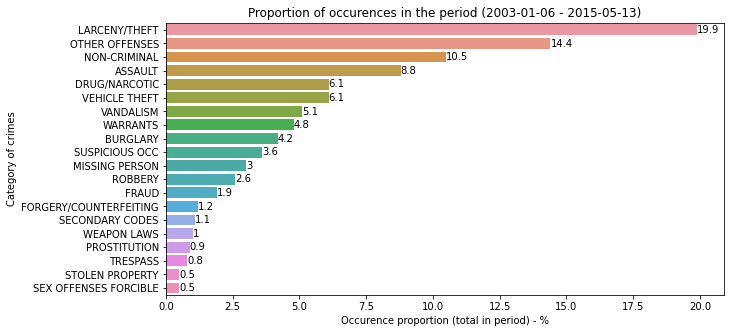

In [7]:
# Creating dataframe that will be used to produce the graph.
df_graph = df_evaluation.groupby(by=['category']).agg({'address': 'count'}).rename(
    columns={'address': 'count'}
).reset_index()
df_graph['prop'] = round(100 * df_graph['count'] / df_graph['count'].sum(), 1)

df_graph.sort_values(by=['count'], inplace=True, ascending=False)

# Graph
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_graph[:20], y='category', x='prop', ax=ax)
ax.set(
    xlabel='Occurence proportion (total in period) - %', ylabel='Category of crimes',
    title=f"Proportion of occurences in the period ({df_evaluation['dates'].dt.date.min()} - {df_evaluation['dates'].dt.date.max()})"
)
ax.bar_label(ax.containers[0]);

## Attribute: 'dates'

In [8]:
df_evaluation = create_date_based_columns(df_evaluation)

df_evaluation.head()

,dates_year,dates_month,dates_hour,dates_day,is_daytime,day_of_week,pd_district,address,x,y,category
0,2015,5,23,13,0,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,WARRANTS
1,2015,5,23,13,0,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,OTHER OFFENSES
2,2015,5,23,13,0,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,OTHER OFFENSES
3,2015,5,23,13,0,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,LARCENY/THEFT
4,2015,5,23,13,0,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,LARCENY/THEFT


## Attribute: 'address'

In [9]:
if 'address' in df_evaluation.columns:
    df_evaluation['simplified_address'] = df_evaluation['address'].apply(address_split)
#     df_evaluation.drop(columns=['address'], inplace=True)
else:
    pass

df_evaluation.head()

,dates_year,dates_month,dates_hour,dates_day,is_daytime,day_of_week,pd_district,address,x,y,category,simplified_address
0,2015,5,23,13,0,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,WARRANTS,oak st
1,2015,5,23,13,0,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,OTHER OFFENSES,oak st
2,2015,5,23,13,0,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,OTHER OFFENSES,vanness av
3,2015,5,23,13,0,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,LARCENY/THEFT,lombard st
4,2015,5,23,13,0,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,LARCENY/THEFT,broderick st


## Attribute: 'x' and 'y' (or longitude and latitude)

In [10]:
transform_cordinates = TransformCordinates()
transform_cordinates.fit(df_evaluation)
transform_cordinates.transform(df_evaluation)[['x', 'y']].describe().T

,count,mean,std,min,25%,50%,75%,max
x,878049.0,-122.422616,0.030354,-122.513642,-122.432952,-122.416420,-122.406959,-120.5
y,878049.0,37.771020,0.456893,37.707879,37.752427,37.775421,37.784369,90.0


## Attribute: pd_district

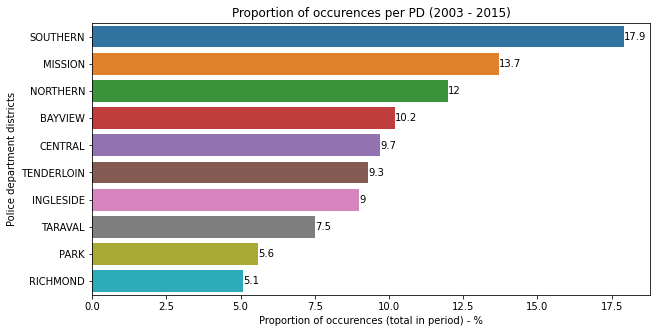

In [11]:
# Creating dataframe that will be used to produce the graph.
df_graph = df_evaluation.groupby(by=['pd_district', 'dates_year']).agg({'simplified_address': 'count'}).rename(
    columns={'simplified_address': 'count'}).reset_index()
df_graph = df_graph.groupby(by=['pd_district']).agg({'count': 'mean'}).reset_index()
df_graph['prop'] = round(100 * df_graph['count'] / df_graph['count'].sum(), 1)
df_graph.sort_values(by=['count'], inplace=True, ascending=False)

# Graph
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_graph, y='pd_district', x='prop', ax=ax)
ax.set(
    xlabel='Proportion of occurences (total in period) - %', ylabel='Police department districts',
    title=f"Proportion of occurences per PD ({df_evaluation['dates_year'].min()} - {df_evaluation['dates_year'].max()})"
)
ax.bar_label(ax.containers[0]);

## Attribute: address

In 'address', we can see that it has a very large cardinality (23228 distinct occurences), and the largest proportion is only 3%. Here, one option can be extracting just the main street name.  name of the street, i.e., to exclude the number of the block.

I found two patterns in the 'Address' atribute:

1. Registries specifying the block of the street, and
1. Registries with two streets separated with a '/'.

In the first case, I will get just the street's name. And, in the second one, I will get just the firsthalf of the name (part before '/').

### Comments:
With this strategy, the number of distinct values decreased to 2031 values (~9% of the original).

In [12]:
df_graph = pd.DataFrame(100 * df_evaluation['address'].value_counts() / df_evaluation['address'].value_counts().sum()).reset_index()
df_graph.columns = ['address', 'proportion']
df_graph.head(10)

,address,proportion
0,800 Block of BRYANT ST,3.021813
1,800 Block of MARKET ST,0.749503
2,2000 Block of MISSION ST,0.580492
3,1000 Block of POTRERO AV,0.462730
4,900 Block of MARKET ST,0.370253
5,0 Block of TURK ST,0.367633
6,0 Block of 6TH ST,0.328455
7,300 Block of ELLIS ST,0.307842
8,400 Block of ELLIS ST,0.294972
9,16TH ST / MISSION ST,0.285178


In [13]:
df_graph['simplified_address'] = df_graph['address'].apply(address_split)
df_temp = df_graph.groupby(by=['simplified_address']).agg({'proportion': 'sum'}).reset_index()
df_temp.sort_values(by='proportion', ascending=False, inplace=True)
df_temp.head(10)

,simplified_address,proportion
1258,mission st,4.184732
1185,market st,3.997157
303,bryant st,3.417007
1872,turk st,1.774161
621,eddy st,1.498208
641,ellis st,1.427369
54,3rd st,1.384091
1362,ofarrell st,1.289564
12,16th st,1.193897
70,6th st,1.108025


## Transforming and splitting data

In [14]:
# Train and validation datasets
df_prepared = df[['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Category']].copy()
df_prepared = snake_case_columns(df_prepared)

df_prepared.head()

,dates,day_of_week,pd_district,address,x,y,category
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,WARRANTS
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,OTHER OFFENSES
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,OTHER OFFENSES
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,LARCENY/THEFT
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,LARCENY/THEFT


In [15]:
# Kaggle test dataset
X_kaggle_test_prepared = X_kaggle_test[['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y']].copy()
X_kaggle_test_prepared = snake_case_columns(X_kaggle_test_prepared)

X_kaggle_test_prepared.head()

,dates,day_of_week,pd_district,address,x,y
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


### Splitting

In [16]:
X = df_prepared.drop(columns=['category'])
y = df_prepared[['category']]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_validation: {X_validation.shape}
y_validation: {y_validation.shape}""")

X_train: (790244, 6)
y_train: (790244, 1)
X_validation: (87805, 6)
y_validation: (87805, 1)


### Transforming X

In [17]:
X_train_transformed = X_train.copy()
X_train_transformed = create_date_based_columns(X_train_transformed)
X_train_transformed = create_simplified_address_column(X_train_transformed)

X_validation_transformed = X_validation.copy()
X_validation_transformed = create_date_based_columns(X_validation_transformed)
X_validation_transformed = create_simplified_address_column(X_validation_transformed)

X_kaggle_test_transformed = X_kaggle_test_prepared.copy()
X_kaggle_test_transformed = create_date_based_columns(X_kaggle_test_transformed)
X_kaggle_test_transformed = create_simplified_address_column(X_kaggle_test_transformed)

pipe = Pipeline([
    ('preprocessing', TransformCordinates(columns=['x', 'y'])),
    ('rare', RareLabelEncoder(tol=0.01, variables=['simplified_address'])),
    ('frequency_address', CountFrequencyEncoder(encoding_method='frequency', variables=['simplified_address'])),
    ('frequency_others', CountFrequencyEncoder(encoding_method='frequency', variables=['pd_district', 'day_of_week']))
])

pipe.fit(X_train_transformed)
X_train_transformed = pipe.transform(X_train_transformed)
X_validation_transformed = pipe.transform(X_validation_transformed)
X_kaggle_test_transformed = pipe.transform(X_kaggle_test_transformed)

X_train_transformed.head(3)

,dates_year,dates_month,dates_hour,dates_day,is_daytime,day_of_week,pd_district,x,y,simplified_address
251113,2011,12,9,28,1,0.147319,0.097218,-122.411519,37.786941,0.776874
392823,2009,11,2,1,0,0.132910,0.119973,-122.424607,37.789043,0.776874
157077,2013,4,22,16,0,0.142289,0.074496,-122.472725,37.731394,0.776874


### Transforming y

#### One hot encoding

In [18]:
ohe = OneHotEncoder(drop_last=False)
y_train_ohe = ohe.fit_transform(y_train)
y_train_ohe = y_train_ohe[sorted(y_train_ohe.columns)]
y_train_ohe.columns = [x[9:] for x in y_train_ohe.columns]

y_validation_ohe = ohe.transform(y_validation)
y_validation_ohe = y_validation_ohe[sorted(y_validation_ohe.columns)]
y_validation_ohe.columns = [x[9:] for x in y_validation_ohe.columns]

print(f"""y_train_transformed: {y_train_ohe.shape}
y_validation_transformed: {y_validation_ohe.shape}""")

y_train_ohe.head(3)

y_train_transformed: (790244, 39)
y_validation_transformed: (87805, 39)


,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
251113,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392823,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157077,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Ordinal encoder

In [19]:
y_train_ordinal = ordinal_encoding_target(y_train, column_name='category')

y_validation_ordinal = ordinal_encoding_target(y_validation, column_name='category')

print(f"""y_train_transformed: {y_train_ohe.shape}
y_validation_transformed: {y_validation_ohe.shape}""")

y_train_ordinal.head(3)

y_train_transformed: (790244, 39)
y_validation_transformed: (87805, 39)


,category
251113,7
392823,1
157077,4


### Exporting prepared data to interim folder

In [20]:
# Predictors / factors
X_train_transformed.to_parquet(INTERIM_DATA + 'X_train_transformed.pqt')
X_validation_transformed.to_parquet(INTERIM_DATA + 'X_validation_transformed.pqt')
X_kaggle_test_transformed.to_parquet(INTERIM_DATA + 'X_kaggle_test_transformed_transformed.pqt')

# Target one hot encoding
y_train_ohe.to_parquet(INTERIM_DATA + 'y_train_ohe.pqt')
y_validation_ohe.to_parquet(INTERIM_DATA + 'y_validation_ohe.pqt')

# Target ordinal encoding
y_train_ordinal.to_parquet(INTERIM_DATA + 'y_train_ordinal.pqt')
y_validation_ordinal.to_parquet(INTERIM_DATA + 'y_validation_ordinal.pqt')

# 2nd: Data preparation

![](../references/02_dataprep_2nd.png)

### Splitting

In [21]:
X = df_prepared.drop(columns=['category'])
y = df_prepared[['category']]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_validation: {X_validation.shape}
y_validation: {y_validation.shape}""")

X_train: (790244, 6)
y_train: (790244, 1)
X_validation: (87805, 6)
y_validation: (87805, 1)


### Transforming X

In [23]:
X_train_transformed

,dates_year,dates_month,dates_hour,dates_day,is_daytime,day_of_week,pd_district,x,y,simplified_address
251113,2011,12,9,28,1,0.147319,0.097218,-122.411519,37.786941,0.776874
392823,2009,11,2,1,0,0.132910,0.119973,-122.424607,37.789043,0.776874
157077,2013,4,22,16,0,0.142289,0.074496,-122.472725,37.731394,0.776874
408259,2009,8,12,20,1,0.142262,0.051560,-122.482454,37.777310,0.776874
334681,2010,9,13,24,1,0.152310,0.119973,-122.423157,37.790209,0.776874
...,...,...,...,...,...,...,...,...,...,...
259178,2011,11,17,14,1,0.138624,0.093148,-122.405895,37.786734,0.012892
365838,2010,4,22,9,0,0.152310,0.179080,-122.396759,37.773173,0.776874
131932,2013,8,22,10,0,0.144286,0.136463,-122.426956,37.769247,0.039924
671155,2005,11,5,4,0,0.152310,0.102038,-122.386942,37.754168,0.776874


In [25]:
X_train_transformed = X_train.copy()
X_train_transformed = create_date_based_columns(X_train_transformed)
X_train_transformed = create_simplified_address_column(X_train_transformed)
# TODO: Create the sine and cosine features for each cyclic feature.
X_train_transformed = cyclic_encoding(df=X_train_transformed, column_name='dates_month', maximum_value=12)
X_train_transformed = cyclic_encoding(df=X_train_transformed, column_name='dates_day', maximum_value=31)
X_train_transformed = cyclic_encoding(df=X_train_transformed, column_name='dates_hour', maximum_value=23)

X_validation_transformed = X_validation.copy()
X_validation_transformed = create_date_based_columns(X_validation_transformed)
X_validation_transformed = create_simplified_address_column(X_validation_transformed)
X_validation_transformed = cyclic_encoding(df=X_validation_transformed, column_name='dates_month', maximum_value=12)
X_validation_transformed = cyclic_encoding(df=X_validation_transformed, column_name='dates_day', maximum_value=31)
X_validation_transformed = cyclic_encoding(df=X_validation_transformed, column_name='dates_hour', maximum_value=23)

X_kaggle_test_transformed = X_kaggle_test_prepared.copy()
X_kaggle_test_transformed = create_date_based_columns(X_kaggle_test_transformed)
X_kaggle_test_transformed = create_simplified_address_column(X_kaggle_test_transformed)
X_kaggle_test_transformed = cyclic_encoding(df=X_kaggle_test_transformed, column_name='dates_month', maximum_value=12)
X_kaggle_test_transformed = cyclic_encoding(df=X_kaggle_test_transformed, column_name='dates_day', maximum_value=31)
X_kaggle_test_transformed = cyclic_encoding(df=X_kaggle_test_transformed, column_name='dates_hour', maximum_value=23)

pipe = Pipeline([
    ('preprocessing', TransformCordinates(columns=['x', 'y'])),
    ('rare', RareLabelEncoder(tol=0.01, variables=['simplified_address'])),
    ('frequency_address', CountFrequencyEncoder(encoding_method='frequency', variables=['simplified_address'])),
    ('frequency_others', CountFrequencyEncoder(encoding_method='frequency', variables=['pd_district']))
])

pipe.fit(X_train_transformed)
X_train_transformed = pipe.transform(X_train_transformed)
X_validation_transformed = pipe.transform(X_validation_transformed)
X_kaggle_test_transformed = pipe.transform(X_kaggle_test_transformed)

X_train_transformed.head(3)

,dates_year,is_daytime,day_of_week,pd_district,x,y,simplified_address,dates_month_sin,dates_month_cos,dates_day_sin,dates_day_cos,dates_hour_sin,dates_hour_cos
251113,2011,1,Wednesday,0.097218,-122.411519,37.786941,0.776874,-2.449294e-16,1.000000,-0.571268,0.820763,0.631088,-0.775711
392823,2009,0,Sunday,0.119973,-122.424607,37.789043,0.776874,-5.000000e-01,0.866025,0.201299,0.979530,0.519584,0.854419
157077,2013,0,Tuesday,0.074496,-122.472725,37.731394,0.776874,8.660254e-01,-0.500000,-0.101168,-0.994869,-0.269797,0.962917


### Transforming y

#### Ordinal encoder

In [26]:
y_train_ordinal = ordinal_encoding_target(y_train, column_name='category')

y_validation_ordinal = ordinal_encoding_target(y_validation, column_name='category')

print(f"""y_train_transformed: {y_train_ohe.shape}
y_validation_transformed: {y_validation_ohe.shape}""")

y_train_ordinal.head(3)

y_train_transformed: (790244, 39)
y_validation_transformed: (87805, 39)


,category
251113,7
392823,1
157077,4


### Exporting prepared data to interim folder

In [27]:
# Predictors / factors
X_train_transformed.to_parquet(INTERIM_DATA + 'X_train_transformed_2nd_dataprep.pqt')
X_validation_transformed.to_parquet(INTERIM_DATA + 'X_validation_transformed_2nd_dataprep.pqt')
X_kaggle_test_transformed.to_parquet(INTERIM_DATA + 'X_kaggle_test_transformed_transformed_2nd_dataprep.pqt')

# Target ordinal encoding
y_train_ordinal.to_parquet(INTERIM_DATA + 'y_train_ordinal.pqt')
y_validation_ordinal.to_parquet(INTERIM_DATA + 'y_validation_ordinal.pqt')